In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101
from keras.applications import MobileNet

from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
train_path = 'train'
test_path = 'test'
val_path = 'val'

In [3]:

train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    
)

In [4]:
size_images = 150
batch_size = 32

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [7]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


In [8]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

In [9]:

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6765 images belonging to 4 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math

# Build MobileNet model
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

# Create a new model
model = Sequential()
model.add(mobilenet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(4, activation='softmax'))  # Assuming num_classes is the number of your classes

# Freeze the layers of the pre-trained model
for layer in mobilenet_model.layers:
    layer.trainable = False

# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Compile the model with an initial learning rate
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Use the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, lr_callback]
)

c:\Users\AILABSERVER\anaconda3\envs\suresh\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [11]:
# Save the model
model.save('mobilenet_model.h5')

In [12]:
# Evaluate the model on the test set
test_results = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

211/211 [==============================] - 178s 846ms/step - loss: 0.1120 - accuracy: 0.9648
Test Loss: 0.11201353371143341
Test Accuracy: 0.9647511839866638


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('mobilenet_model.h5')

# Create a test generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

# Initialize lists to accumulate predictions and true labels
all_predictions = []
all_true_labels = []

# Loop through all batches in the test generator
for _ in range(len(test_generator)):
    images, labels = test_generator.next()

    # Predictions on the current batch
    batch_predictions = loaded_model.predict(images)
    all_predictions.extend(batch_predictions)
    
    # True labels for the current batch
    batch_true_labels = np.argmax(labels, axis=1)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Extract predicted labels from all predictions
predicted_labels = np.argmax(all_predictions, axis=1)




Found 6769 images belonging to 4 classes.


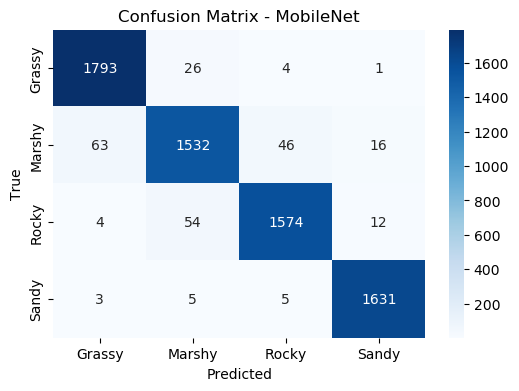

In [14]:
# Confusion Matrix
conf_mat = confusion_matrix(all_true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - MobileNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [15]:
# Classification Report
print("Classification Report of MobileNet:")
print(classification_report(all_true_labels, predicted_labels, target_names=class_names))

Classification Report of MobileNet:
              precision    recall  f1-score   support

      Grassy       0.96      0.98      0.97      1824
      Marshy       0.95      0.92      0.94      1657
       Rocky       0.97      0.96      0.96      1644
       Sandy       0.98      0.99      0.99      1644

    accuracy                           0.96      6769
   macro avg       0.96      0.96      0.96      6769
weighted avg       0.96      0.96      0.96      6769



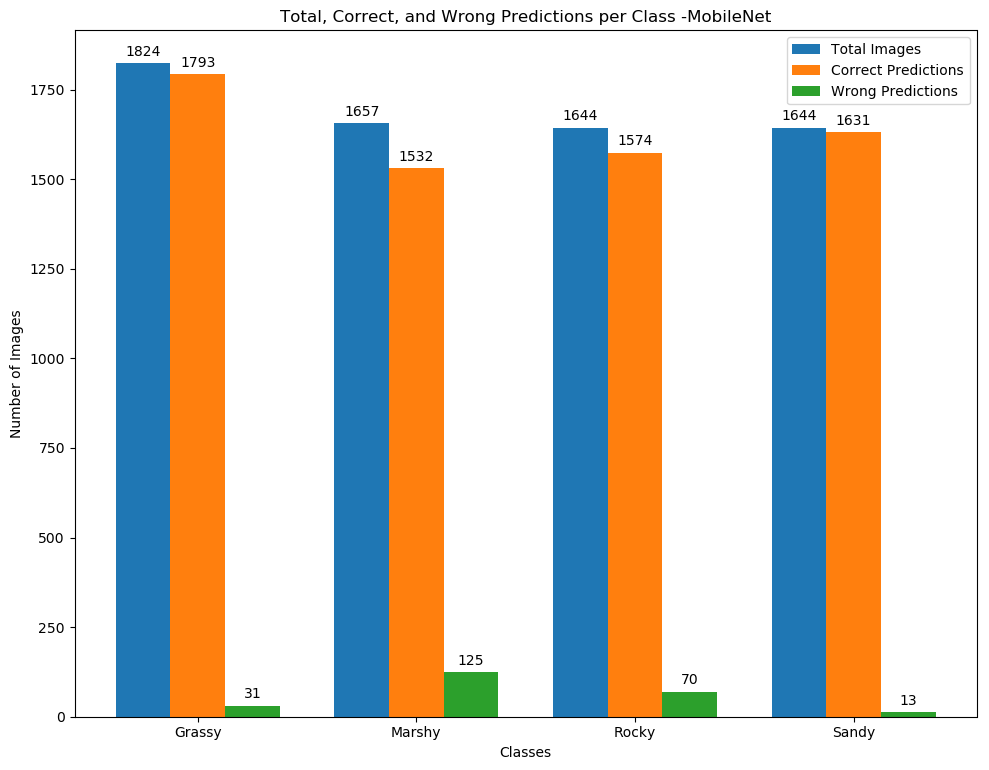

In [16]:
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names

# Print the number of images classified correctly and wrongly in each class
correctly_classified = np.diag(conf_mat)
wrongly_classified = np.sum(conf_mat, axis=1) - correctly_classified

# Total number of images in each class
total_images_per_class = np.sum(conf_mat, axis=1)

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, total_images_per_class, width, label='Total Images')
rects2 = ax.bar(x, correctly_classified, width, label='Correct Predictions')
rects3 = ax.bar(x + width, wrongly_classified, width, label='Wrong Predictions')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Total, Correct, and Wrong Predictions per Class -MobileNet')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Display the number of images on top of each bar with proper spacing
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 1.3])  # Increase the value in the last argument if necessary

plt.show()

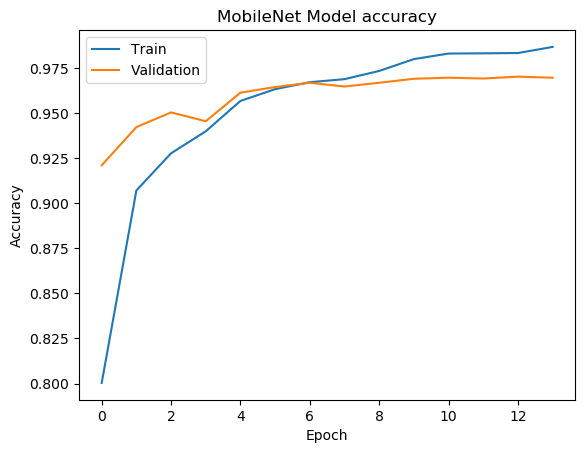

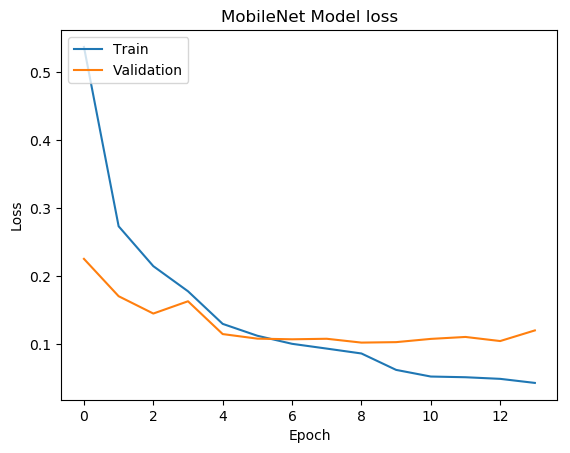

In [17]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object you get after training your DenseNet model
# Replace 'history' with the actual variable name you have

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [1]:
import numpy as np

def calculate_metrics_and_report(confusion_matrix, class_names, total_per_class):
  """
  This function calculates and displays various metrics and a classification report.

  Args:
      confusion_matrix: A numpy array representing the confusion matrix.
      class_names: A list containing the names of the classes.
      total_per_class (optional): A list containing the total number of images per class 
                                    (if available). Used to estimate FN_X.

  Returns:
      None (prints the metrics and report to the console).
  """

  # Calculate class-wise elements
  TP = np.diag(confusion_matrix)  # True positives (diagonal elements)
  FP = confusion_matrix.sum(axis=0) - TP  # False positives (row sums minus diagonals)
  FN = confusion_matrix.sum(axis=1) - TP  # False negatives (column sums minus diagonals)
  TN = confusion_matrix.sum() - (TP + FP + FN)  # True negatives (all elements minus TP, FP, FN)

  # Calculate totals
  total_support = confusion_matrix.sum(axis=0)  # Total predicted instances per class
  total_ground_truth = confusion_matrix.sum(axis=1)  # Total true instances per class

  # Calculate class-wise accuracy
  class_wise_accuracy = TP / (TP + FP + FN)

  # Macro-average (requires FN values)
  if total_per_class is not None:
      # Estimate FN_X if total images per class are provided
      FN_X = total_per_class - TP
      macro_precision = np.mean(TP / (TP + FP))
      macro_recall = np.mean(TP / FN_X)
      macro_f1 = np.mean(2 * (macro_precision * macro_recall) / (macro_precision + macro_recall))
  else:
      macro_precision = np.nan
      macro_recall = np.nan
      macro_f1 = np.nan

  # Micro-average
  micro_precision = TP.sum() / (TP.sum() + FP.sum())
  micro_recall = TP.sum() / (TP.sum() + FN.sum()) if total_per_class is not None else np.nan  # Avoid division by zero
  micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

  # Build the classification report string
  report = "             Precision    Recall  F1-Score   Support\n"
  for i, class_name in enumerate(class_names):
      precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
      recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
      f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
      support = total_predicted_instances = total_support[i]
      report += f"{class_name:14}  {precision:.4f}  {recall:.4f}  {f1:.4f}         {support}\n"

  # Add support for all classes
  report += f"accuracy         {TP.sum() / confusion_matrix.sum():.4f}        {total_ground_truth.sum()}\n"

  # Print results
  print("Class-wise Accuracy:")
  for i, class_name in enumerate(class_names):
      print(f"\t{class_name}: {class_wise_accuracy[i]:.4f}")
  print("\nClassification Report:")
  print(report)

  print("\nMacro Average (requires FN values):")
  print(f"\tPrecision: {macro_precision:.4f}")
  print(f"\tRecall: {macro_recall:.4f}")  # Print NaN if FN_X not available
  print(f"\tF1-Score: {macro_f1:.4f}")  # Print NaN if FN_X not


# Example usage
confusion_matrix = np.array([[1793, 26, 4, 1],
                             [63, 1532, 46, 16],
                             [4, 54, 1574, 12],
                             [3, 5, 5, 1631]])

class_names = ["Grassy", "Marshy", "Rocky", "Sandy"]
# Example: Assuming you have total images per class (replace with your actual values)
total_per_class = [1824, 1657, 1644, 1644]

report = calculate_metrics_and_report(confusion_matrix, class_names,total_per_class)
print(report)

Class-wise Accuracy:
	Grassy: 0.9467
	Marshy: 0.8794
	Rocky: 0.9264
	Sandy: 0.9749

Classification Report:
             Precision    Recall  F1-Score   Support
Grassy          0.9624  0.9830  0.9726         1863
Marshy          0.9474  0.9246  0.9359         1617
Rocky           0.9662  0.9574  0.9618         1629
Sandy           0.9825  0.9921  0.9873         1660
accuracy         0.9647        6769


Macro Average (requires FN values):
	Precision: 0.9647
	Recall: 54.5105
	F1-Score: 1.8958
None
